In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

In [2]:
df = pd.read_pickle('bert_embeddings.pkl')
df.head(3)

,title,abstract,relatedwork_text,main_text,rw_citations,full_citations,BERT_embeddings
paper_id,,,,,,,
859921,Summarizing Reviews with Variable-length Synta...,Abstract. We present a novel summarization fra...,We first look at how text excerpts are extract...,Abstract. We present a novel summarization fra...,"[5965756, 1599046, 3177797, 444032, 6884774]","[1599046, 11055565, 16393334, 2481864, 5965756...","[-0.5292661, 0.96171594, 0.7239495, 0.09007428..."
129124,Can Document Selection Help Semi-supervised Le...,Annotating training data for event extraction ...,Self-training has been applied to several natu...,Annotating training data for event extraction ...,"[1398439, 7419156, 11187670, 8336242, 15894892...","[1398439, 7419156, 7579604, 11187670, 8336242,...","[-0.7070601, 0.5793047, 0.30019873, 0.451895, ..."
1345235,Optimizing Sparse Matrix–Vector Product Comput...,Large-scale scientific applications frequently...,A variety of different data and computation re...,Large-scale scientific applications frequently...,"[1794629, 9580801, 120335238, 15090599, 208582...","[1794629, 9580801, 120335238, 15090599, 208582...","[-0.72422814, 0.38941112, 0.50098884, -0.02656..."


In [16]:
# Split data to 80% trainset and 20% testset
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

train_labels = pd.read_csv('train_mod.csv', index_col=0)

In [17]:
def model_eval(model, train_labels):
    
    result = pd.DataFrame(train_labels.loc[:, 'label'], dtype=np.int8)
    result['model_label'] = 0
    
    df_train_new = df_train.copy()
    df_train_new.reset_index(inplace=True)
    
    for i in train_labels.index:
        id1 = train_labels.loc[i, 'paper1_id']
        id2 = train_labels.loc[i, 'paper2_id']
        #c1 = model.predict(df_train.loc[str(id1), 'BERT_embeddings'].reshape(1, -1))[0]
        #c2 = model.predict(df_train.loc[str(id2), 'BERT_embeddings'].reshape(1, -1))[0]
        c1 = model.predict(embeddings_test[int(df_train_new[df_train_new.paper_id == str(id1)].index[0])].reshape(1, -1))[0]
        c2 = model.predict(embeddings_test[int(df_train_new[df_train_new.paper_id == str(id2)].index[0])].reshape(1, -1))[0]
        
        result.loc[i, 'model_label'] = int(c1 == c2)
        
    fn = len(result.loc[(result.label == 1) & (result.model_label == 0)])
    tp = len(result.loc[(result.label == 1) & (result.model_label == 1)])
    tn = len(result.loc[(result.label == 0) & (result.model_label == 0)])
    fp = len(result.loc[(result.label == 0) & (result.model_label == 1)])
    
    acc = (tp+tn)/(tp+fp+tn+fn)
    recall = tp/(tp+fn)
        
    return acc, recall

In [18]:
embeddings = []
for i in df_train.index:
    emb = df_train.loc[i, 'BERT_embeddings']
    embeddings.append(emb)

embeddings = np.array(embeddings)
embeddings.shape

(21933, 768)

In [19]:
from tqdm import tqdm

recall_result = []
acc_result = []
for n1 in tqdm(range(7,15)):
    recs = []
    accs = []
    for n2 in range(5,11):
        embeddings_test = PCA(n_components = n1).fit_transform(embeddings)
        kmeans_model = KMeans(n_clusters=n2).fit(embeddings_test)
        rec = model_eval(kmeans_model, train_labels)[1]
        recs.append(rec)
        acc = model_eval(kmeans_model, train_labels)[0]
        accs.append(acc)
    recall_result.append(recs)    
    acc_result.append(accs)

100%|█████████████████████████████████████████████| 8/8 [04:58<00:00, 37.34s/it]


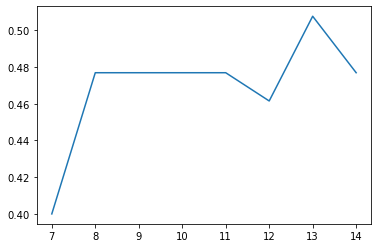

In [20]:
import matplotlib.pyplot as plt

x = np.array(range(7,15))
y_recall = []
for result in recall_result:
    y_recall.append(max(result))
y_acc = []
for result in acc_result:
    y_acc.append(max(result))

plt.plot(x, y_recall)

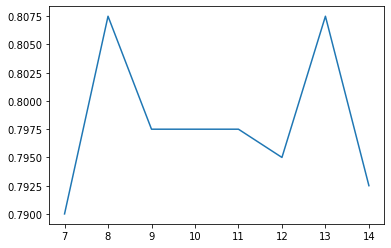

In [21]:
plt.plot(x, y_acc)

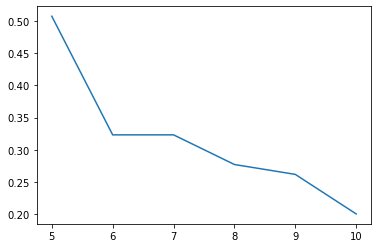

In [28]:
x1 = range(5,11)
plt.plot(x1, recall_result[6])

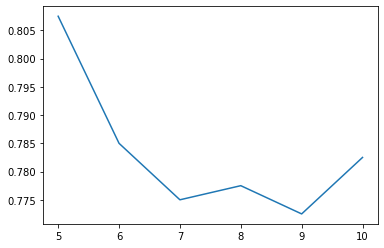

In [30]:
x1 = range(5,11)
plt.plot(x1, acc_result[6])

In [32]:
train_labels['label'].sum()

65